In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 3.9MB/s 
     |████████████████████████████████| 9.5MB 16.3MB/s 
     |████████████████████████████████| 2.1MB 31.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go

#from pylab import rcParams 

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from fbprophet import Prophet

import warnings

In [3]:
def plotar_grafico(var_data, var_x, var_y, var_title, var_media_movel=""):
    plt.figure(figsize=(15,5))

    sns.lineplot(x=var_x, y=var_y, data=var_data[:50], palette="tab10", linewidth=1.5)

    if var_media_movel != "":
        sns.lineplot(x='Data', y= var_media_movel, data= var_data[:50])

    plt.title(var_title)
    plt.xticks(rotation= 30)
    plt.show()

In [4]:
def plotar_decompose(var_data,var_coluna, var_title, var_model='additive'):
    
    decomposicao =  seasonal_decompose(var_data[var_coluna], model=var_model)

    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,10))

    decomposicao.observed.plot(ax=ax1)
    decomposicao.trend.plot(ax=ax2)
    decomposicao.seasonal.plot(ax=ax3)
    decomposicao.resid.plot(ax=ax4)

    ax1.set_ylabel('Observed')
    ax2.set_ylabel('trend')
    ax3.set_ylabel('seasonal')
    ax4.set_ylabel('resid')

    fig.axes[0].set_title(var_title)

In [8]:
url_file = 'https://raw.githubusercontent.com/mboliveira2006/analise_previsao_series_temporais/main/dados/A105613189_28_143_208.csv'

In [9]:
dados = pd.read_csv(url_file, encoding='ISO-8859-1', sep=';', skiprows=3, skipfooter=16, engine='python') 
dados.head()

,Ano Diagnóstico,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Total
0,2001,8088,6542,8095,7305,7656,6805,6987,8065,6697,7524,6874,6627,87265
1,2002,8013,7346,7961,8771,7784,6713,7746,8330,7654,8200,7532,6809,92859
2,2003,8115,7985,7474,7975,8024,7082,7949,7585,8136,8521,7624,7303,93773
3,2004,7574,6743,8574,8089,7763,7314,7825,8232,7901,8016,7753,7196,92980
4,2005,7432,6748,8441,7958,8019,7781,7282,8391,7690,7186,7587,7541,92056


In [10]:
dados = dados.drop("Total",axis=1)
dados = dados.drop(19,axis=0)

In [11]:
dados_time_series = dados.melt(id_vars="Ano Diagnóstico", value_name="Casos", var_name="Mes")

dados_time_series['Data'] = dados_time_series["Ano Diagnóstico"] + "-" + dados_time_series["Mes"]


In [12]:
dados_time_series.head()

,Ano Diagnóstico,Mes,Casos,Data
0,2001,Jan,8088,2001-Jan
1,2002,Jan,8013,2002-Jan
2,2003,Jan,8115,2003-Jan
3,2004,Jan,7574,2004-Jan
4,2005,Jan,7432,2005-Jan


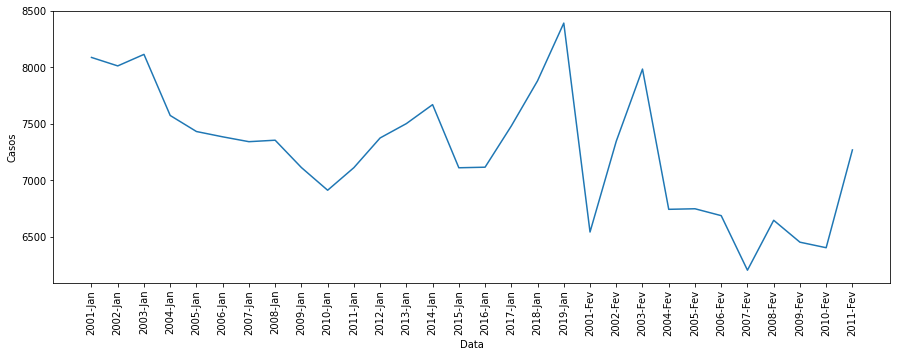

In [13]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Data', y='Casos', data=dados_time_series[:30])

plt.xticks(rotation= 90)
plt.show()

In [14]:
dados_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ano Diagnóstico  228 non-null    object
 1   Mes              228 non-null    object
 2   Casos            228 non-null    int64 
 3   Data             228 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.2+ KB


In [ ]:
#dados_time_series['data_new'] = dados_time_series['data'].map(str) + '-01'

In [15]:
meses_dict = {'Jan':'Jan',
                'Fev':'Feb',
                'Mar':'Mar',
                'Abr':'Apr',
                'Mai':'May',
                'Jun':'Jun',
                'Jul':'Jul',
                'Ago':'Aug',
                'Set':'Sep',
                'Out':'Oct',
                'Nov':'Nov',
                'Dez':'Dec'}

In [16]:
meses_dict_number = {'Jan':1,
                'Feb':2,
                'Mar':3,
                'Apr':4,
                'May':5,
                'Jun':6,
                'Jul':7,
                'Aug':8,
                'Sep':9,
                'Oct':10,
                'Nov':11,
                'Dec':12}

In [17]:
dados_time_series['Mes'] = dados_time_series['Mes'].map(meses_dict)

In [18]:
dados_time_series.sample(5)

,Ano Diagnóstico,Mes,Casos,Data
40,2003,Mar,7474,2003-Mar
202,2013,Nov,6939,2013-Nov
33,2015,Feb,6160,2015-Fev
93,2018,May,7892,2018-Mai
62,2006,Apr,6804,2006-Abr


In [19]:
dados_time_series['Data'] = dados_time_series["Ano Diagnóstico"] + "-" + dados_time_series["Mes"]

In [20]:
dados_time_series['Data'] = pd.to_datetime(dados_time_series['Data'])

In [ ]:
#dados_time_series['Mes'] = dados_time_series['Data'].map(dados_time_series['Data'].dt.month)

In [21]:
dados_time_series['Mes'] = dados_time_series['Mes'].map(meses_dict_number)


In [22]:
dados_time_series = dados_time_series[['Data','Casos','Mes']]

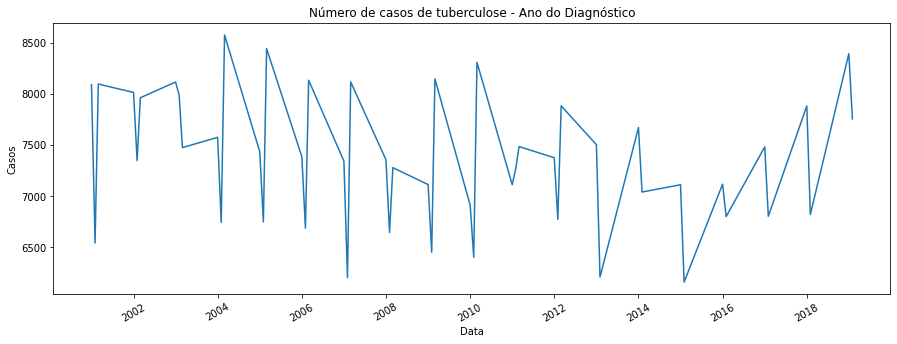

In [23]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico')

In [24]:
#ordenar o dataset pela data
dados_time_series =  dados_time_series.sort_values(by=['Data'])

dados_time_series = dados_time_series.reset_index(drop= True)

In [25]:
dados_time_series.head()

,Data,Casos,Mes
0,2001-01-01,8088,1
1,2001-02-01,6542,2
2,2001-03-01,8095,3
3,2001-04-01,7305,4
4,2001-05-01,7656,5


In [26]:
dados_time_series['MM_3'] = dados_time_series['Casos'].rolling(3).mean()

In [27]:
dados_time_series['MM_6'] = dados_time_series['Casos'].rolling(6).mean()

In [28]:
dados_time_series['MM_3c'] = dados_time_series['Casos'].rolling(3, center= True).mean()

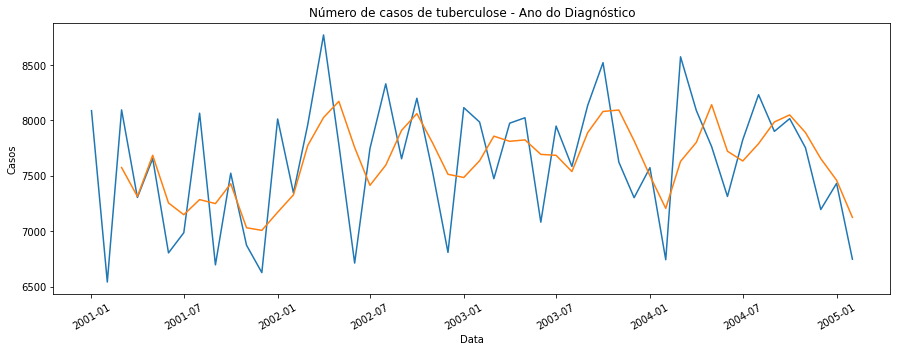

In [29]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico','MM_3')

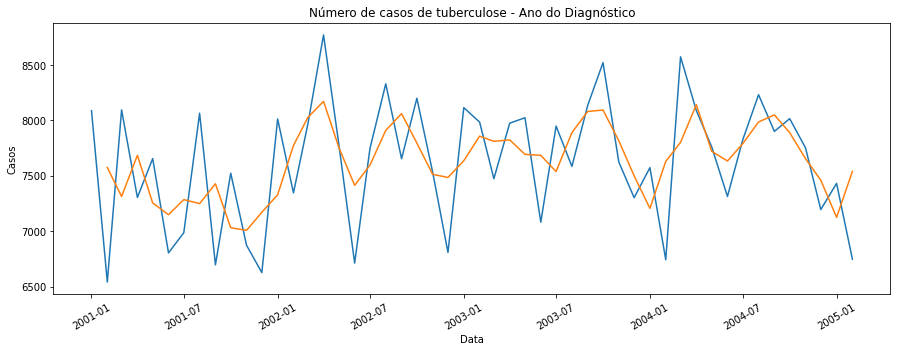

In [30]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico','MM_3c')

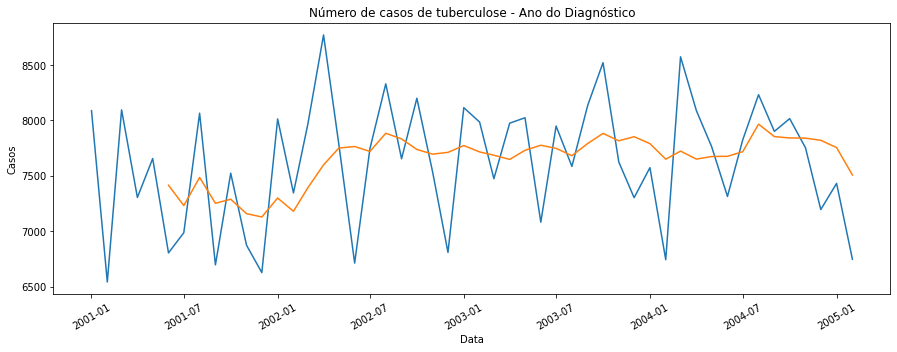

In [31]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico','MM_6')

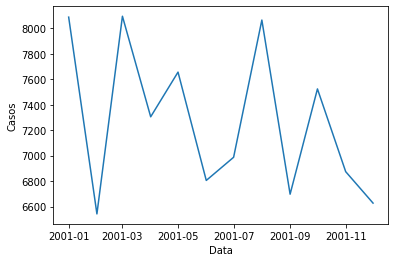

In [32]:
sns.lineplot(x='Data', y='Casos', data=dados_time_series[:12])

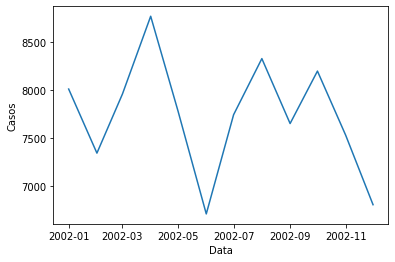

In [33]:
sns.lineplot(x='Data', y='Casos', data=dados_time_series[12:24])

In [34]:
dados_time_series['Ano'] = dados_time_series['Data'].dt.year
dados_time_series['Mes'] = dados_time_series['Data'].dt.month


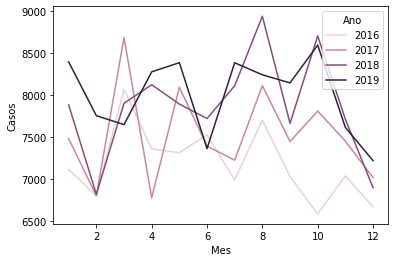

In [35]:
sns.lineplot(x='Mes', y='Casos', data=dados_time_series.query("Ano in[2019,2018,2017,2016]"), hue='Ano')

In [36]:
dados_time_series = dados_time_series.set_index('Data')

In [37]:
dados_time_series

,Casos,Mes,MM_3,MM_6,MM_3c,Ano
Data,,,,,,
2001-01-01,8088,1,NaN,NaN,NaN,2001
2001-02-01,6542,2,NaN,NaN,7575.000000,2001
2001-03-01,8095,3,7575.000000,NaN,7314.000000,2001
2001-04-01,7305,4,7314.000000,NaN,7685.333333,2001
2001-05-01,7656,5,7685.333333,NaN,7255.333333,2001
...,...,...,...,...,...,...
2019-08-01,8239,8,7994.666667,8048.166667,8254.666667,2019
2019-09-01,8143,9,8254.666667,8130.666667,8324.666667,2019
2019-10-01,8592,10,8324.666667,8183.666667,8116.666667,2019


In [38]:
decomposicao =  seasonal_decompose(dados_time_series['Casos'])

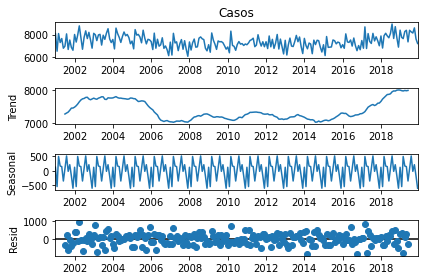

In [39]:
decomposicao.plot();


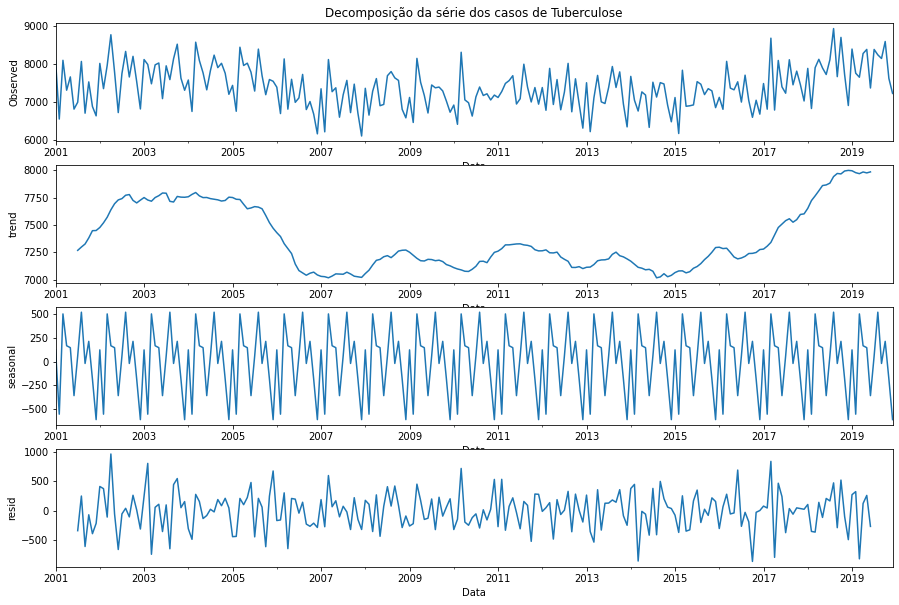

In [40]:
plotar_decompose(dados_time_series,'Casos','Decomposição da série dos casos de Tuberculose')

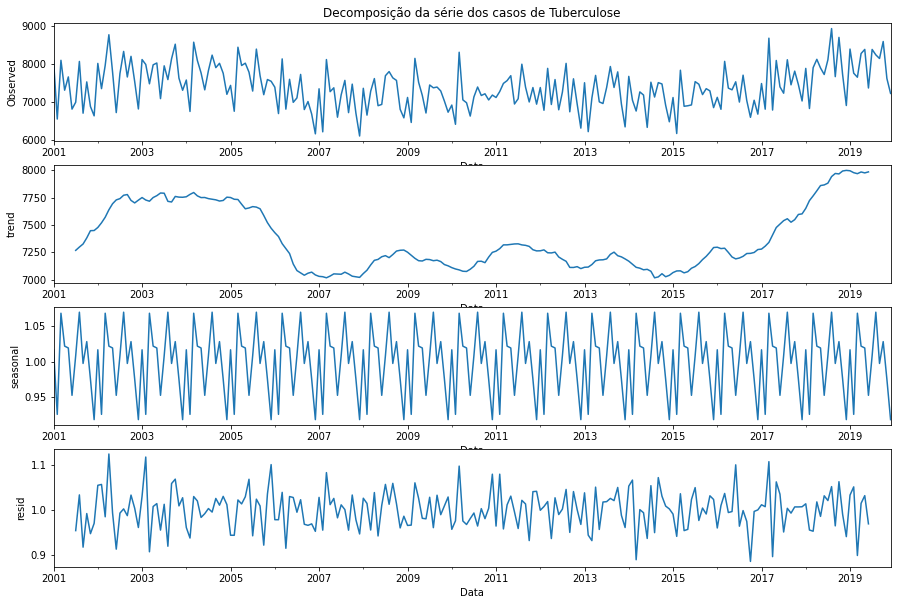

In [41]:
plotar_decompose(dados_time_series,'Casos', 'Decomposição da série dos casos de Tuberculose', 'multiplicative')

In [42]:
url_passageiros = 'https://raw.githubusercontent.com/mboliveira2006/analise_previsao_series_temporais/main/dados/AirPassengers.csv'
dados_passengers = pd.read_csv(url_passageiros)
dados_passengers['Month'] =  pd.to_datetime(dados_passengers['Month'])
dados_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


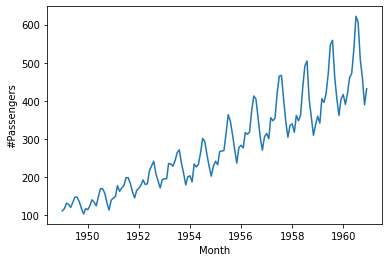

In [43]:
sns.lineplot(x ='Month', y ='#Passengers', data = dados_passengers)

In [44]:
dados_passengers

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [45]:
dados_passengers = dados_passengers.set_index('Month')


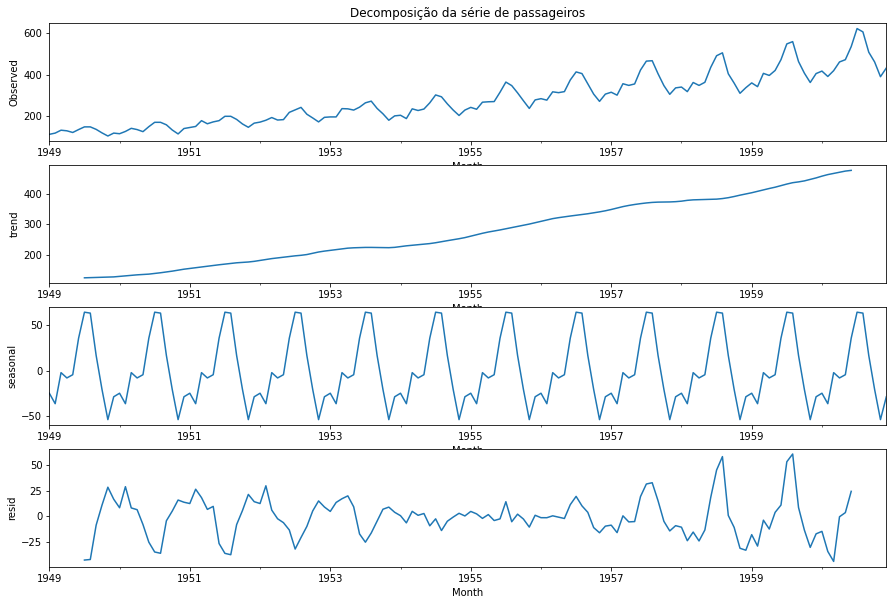

In [46]:
decomposicao_p =  seasonal_decompose(dados_passengers['#Passengers'])
#decomposicao.plot();

plotar_decompose(dados_passengers,'#Passengers', 'Decomposição da série de passageiros')

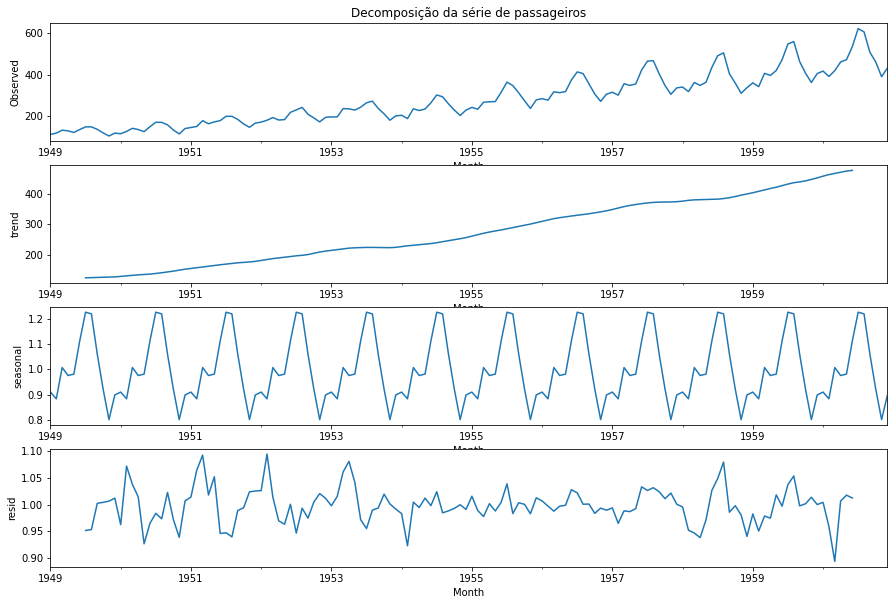

In [47]:
decomposicao_p =  seasonal_decompose(dados_passengers['#Passengers'], model='multiplicative')
#decomposicao.plot(2);


plotar_decompose(dados_passengers,'#Passengers', 'Decomposição da série de passageiros', 'multiplicative')

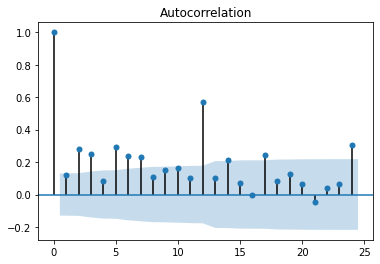

In [48]:
plot_acf(dados_time_series['Casos']);

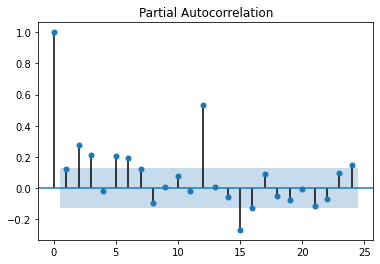

In [49]:
plot_pacf(dados_time_series['Casos']);

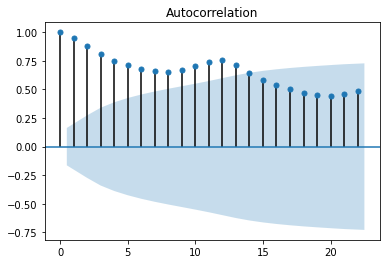

In [50]:
plot_acf(dados_passengers['#Passengers']);


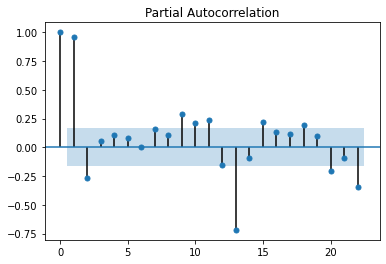

In [51]:
plot_pacf(dados_passengers['#Passengers']);

In [52]:
dados_passengers.reset_index(inplace=True)
dados_passengers.rename({'Month':'Data', '#Passengers':'Passageiros'}, axis=1, inplace=True)

In [53]:
dados_passengers['Mes'] = dados_passengers['Data'].dt.month
dados_passengers['Ano'] = dados_passengers['Data'].dt.year

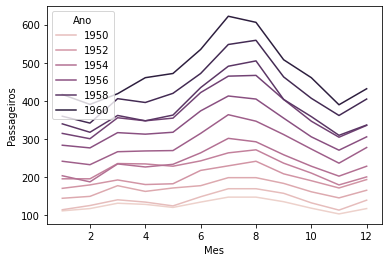

In [54]:
sns.lineplot(x='Mes', y='Passageiros', data= dados_passengers, hue='Ano')

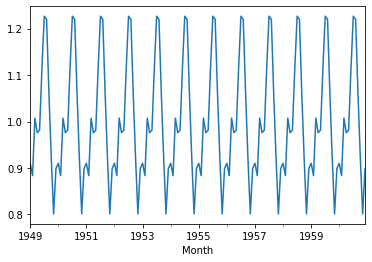

In [55]:
decomposicao_p.seasonal.plot()

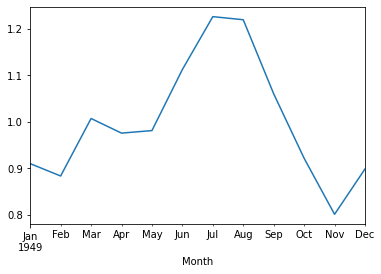

In [56]:
decomposicao_p.seasonal[:12].plot()

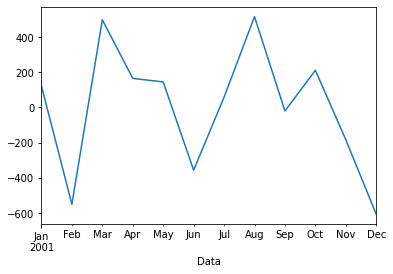

In [57]:
decomposicao.seasonal[:12].plot()

In [120]:
modelo_arima = ARIMA(dados_time_series['Casos'].values.astype('float32'), order=[0,0,0])
modelo_arima_treinado = modelo_arima.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




In [121]:
modelo_arima_treinado

In [122]:
modelo_arima_treinado.forecast(12)[0]

array([7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
       7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
       7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772])

In [124]:
dados_treino = dados_time_series.query("Ano != 2019")
dados_teste = dados_time_series.query('Ano == 2019')

In [125]:
modelo_arima = ARIMA(dados_treino['Casos'].values.astype('float32'), order=[12,1,2])#Autoregressivo order=[1,0,0], média mvel   ordem 1 order=[0,0,1]
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



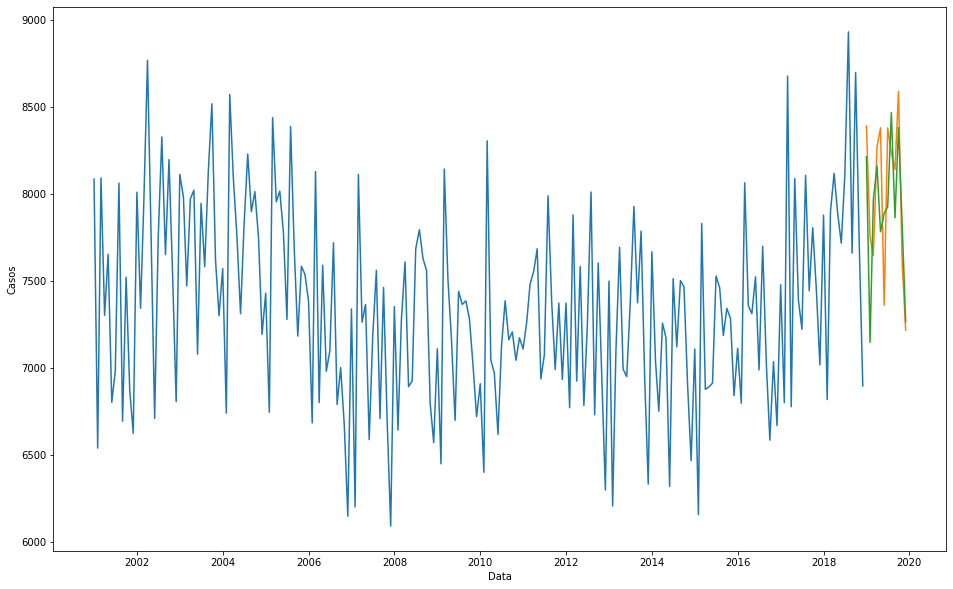

In [160]:
dados_teste['Previsao'] = previsao
plt.figure(figsize=(16,10))
sns.lineplot(x='Data', y='Casos', data= dados_treino)
sns.lineplot(x='Data', y='Casos', data= dados_teste)
sns.lineplot(x='Data', y='Previsao', data= dados_teste)


In [127]:
dados_treino_passageiros = dados_passengers.query("Ano != 1960")
dados_teste_passageiros = dados_passengers.query('Ano == 1960')

In [72]:
modelo_arima = ARIMA(dados_treino_passageiros['Passageiros'].values.astype('float32'), order=[2,1,2])#Autoregressivo order=[1,0,0], média mvel   ordem 1 order=[0,0,1]
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


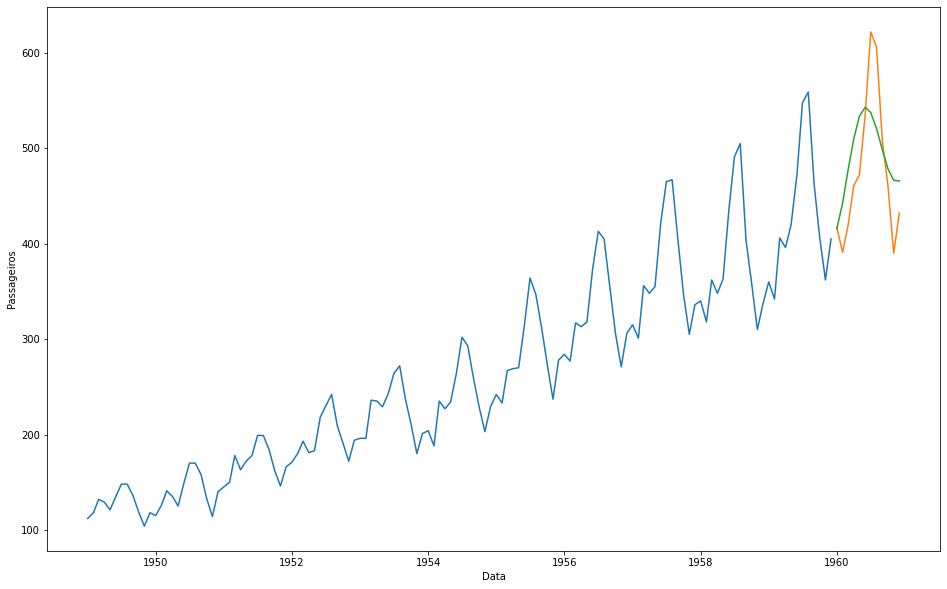

In [67]:
dados_teste_passageiros['Previsao'] = previsao
plt.figure(figsize=(16,10))
sns.lineplot(x='Data', y='Passageiros', data= dados_treino_passageiros)
sns.lineplot(x='Data', y='Passageiros', data= dados_teste_passageiros)
sns.lineplot(x='Data', y='Previsao', data= dados_teste_passageiros)

In [84]:
modelo_autoarima = auto_arima(dados_treino['Casos'].values,error_action='ignore'
                          , trace=True, seasonal=True, m=12 , ma)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3289.199, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3249.086, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3460.524, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3312.298, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3246.454, Time=1.86 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.22 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3398.593, Time=1.15 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3242.479, Time=2.41 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3246.995, Time=0.89 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.80 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3

In [80]:
modelo_autoarima

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [85]:
modelo_autoarima.predict(12)

array([8159.98112671, 7481.16437183, 7963.33559255, 8121.14059974,
       7988.91051071, 7904.76381516, 8176.77704736, 8490.76305546,
       7925.54099216, 8480.63767896, 7961.66783448, 7587.81571076])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


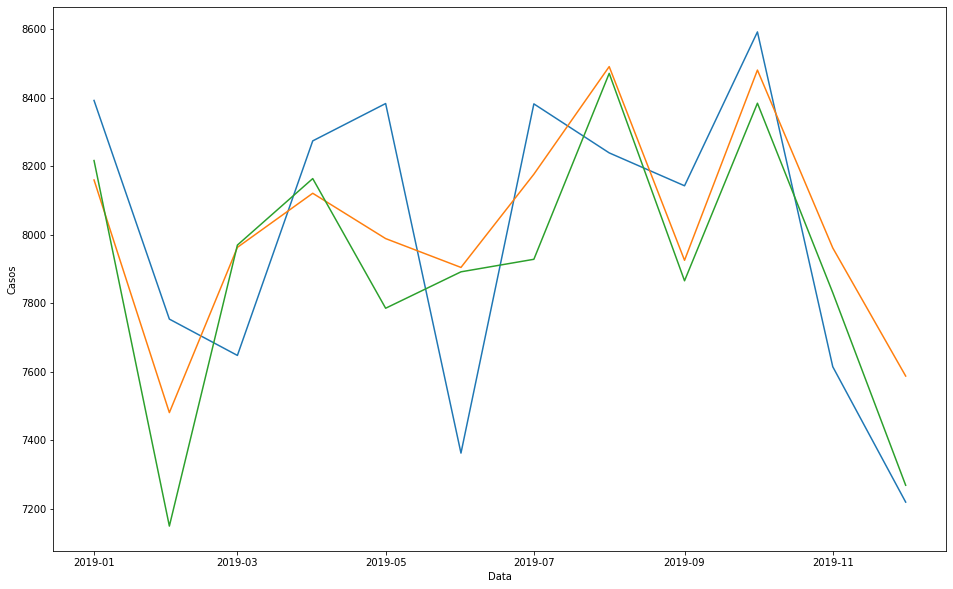

In [90]:
previsao_autoarima = modelo_autoarima.predict(12)

dados_teste['Previsao_autoarima'] = previsao_autoarima

plt.figure(figsize=(16,10))
#sns.lineplot(x='Data', y='Casos', data= dados_treino)
sns.lineplot(x='Data', y='Casos', data= dados_teste)
sns.lineplot(x='Data', y='Previsao_autoarima', data= dados_teste)
sns.lineplot(x='Data', y='Previsao', data= dados_teste)

In [96]:
resultado_autoarima = mean_squared_error(dados_teste['Casos'], dados_teste['Previsao_autoarima'])
resultado_arima = mean_squared_error(dados_teste['Casos'], dados_teste['Previsao'])
print(f"Autoarima = {resultado_autoarima}")
print(f"Arima = {resultado_arima}")

Autoarima = 93378.93285752926
Arima = 131384.4418748081


##Previsão usando o Facebook Prophet

In [100]:
dados_treino_passageiros_profeta = dados_treino_passageiros[['Data','Passageiros']].rename({'Data':'ds', 'Passageiros':'y'}, axis=1)

In [111]:
modelo_profeta = Prophet(seasonality_mode='multiplicative')
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_passageiros_profeta[['ds','y']])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [112]:
#Criar na linha temporal do modelo o futuro
futuro = modelo_profeta_treinado.make_future_dataframe(periods=12,freq='M')
futuro


,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01
...,...
139,1960-07-31
140,1960-08-31
141,1960-09-30
142,1960-10-31


In [113]:
#fazer a previsão
resultado_profeta = modelo_profeta_treinado.predict(futuro)


In [106]:
resultado_profeta

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,108.446107,58.652968,108.989002,108.446107,108.446107,-24.724897,-24.724897,-24.724897,-24.724897,-24.724897,-24.724897,0.0,0.0,0.0,83.721210
1,1949-02-01,110.624181,51.868450,102.063573,110.624181,110.624181,-34.382555,-34.382555,-34.382555,-34.382555,-34.382555,-34.382555,0.0,0.0,0.0,76.241626
2,1949-03-01,112.591474,91.233474,139.449235,112.591474,112.591474,3.105411,3.105411,3.105411,3.105411,3.105411,3.105411,0.0,0.0,0.0,115.696885
3,1949-04-01,114.769548,82.234662,135.260639,114.769548,114.769548,-5.768648,-5.768648,-5.768648,-5.768648,-5.768648,-5.768648,0.0,0.0,0.0,109.000900
4,1949-05-01,116.877362,85.177471,137.901410,116.877362,116.877362,-5.379491,-5.379491,-5.379491,-5.379491,-5.379491,-5.379491,0.0,0.0,0.0,111.497871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-07-31,467.254909,506.553252,559.638666,466.952002,467.492659,66.342561,66.342561,66.342561,66.342561,66.342561,66.342561,0.0,0.0,0.0,533.597470
140,1960-08-31,470.249335,457.280769,510.611814,469.888771,470.544958,12.617259,12.617259,12.617259,12.617259,12.617259,12.617259,0.0,0.0,0.0,482.866594
141,1960-09-30,473.147167,420.133927,470.715598,472.724465,473.488122,-27.160103,-27.160103,-27.160103,-27.160103,-27.160103,-27.160103,0.0,0.0,0.0,445.987064
142,1960-10-31,476.141594,389.295039,440.567908,475.654291,476.557220,-61.655518,-61.655518,-61.655518,-61.655518,-61.655518,-61.655518,0.0,0.0,0.0,414.486076


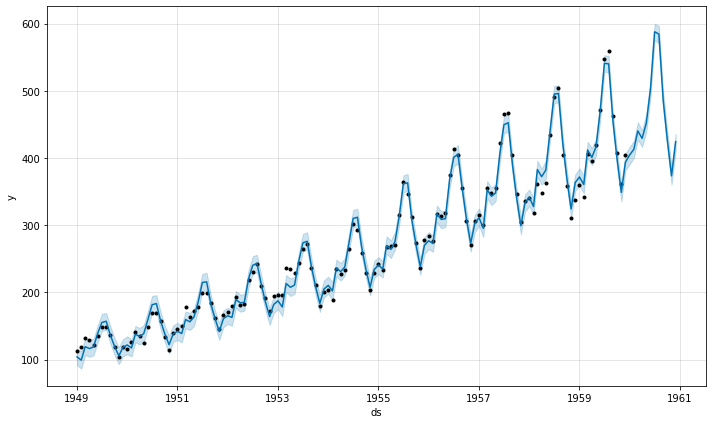

In [114]:
modelo_profeta_treinado.plot(resultado_profeta);

Dados Tuberculose

In [128]:
dados_treino.reset_index(inplace=True)

In [130]:
dados_treino_profeta = dados_treino[['Data','Casos']].rename({'Data':'ds', 'Casos':'y'}, axis=1)

In [137]:
modelo_profeta = Prophet(seasonality_mode='multiplicative')#seasonality_mode='multiplicative'
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_profeta[['ds','y']])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [135]:
#Criar na linha temporal do modelo o futuro
futuro = modelo_profeta_treinado.make_future_dataframe(periods=12,freq='M')
resultado_profeta = modelo_profeta_treinado.predict(futuro)

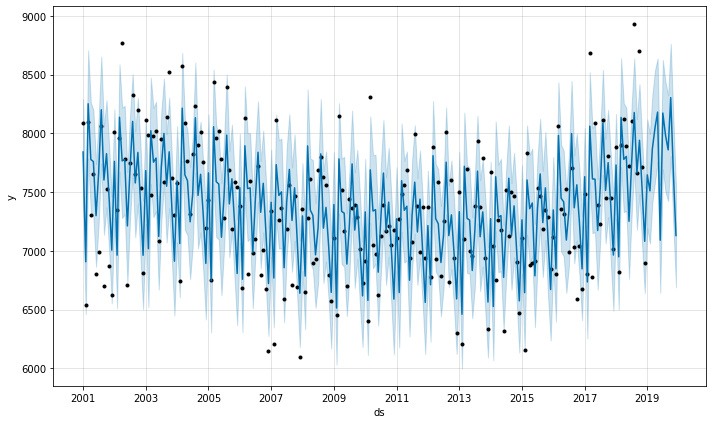

In [136]:
modelo_profeta_treinado.plot(resultado_profeta);

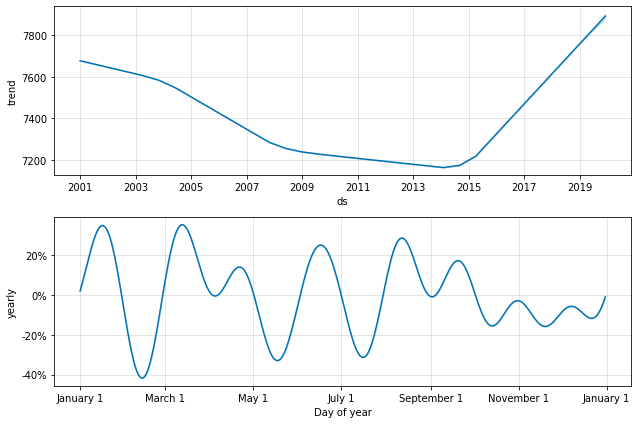

In [138]:
modelo_profeta_treinado.plot_components(resultado_profeta);

In [161]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dados_teste.index, y=dados_teste['Casos'], name='Teste',))
fig.add_trace(go.Scatter(x=dados_treino_profeta['ds'], y=dados_treino_profeta['y'], name='Actual',))
fig.add_trace(go.Scatter(x=resultado_profeta['ds'], y=resultado_profeta['yhat'], name='Predicted',))
fig.show()

In [179]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=dados_treino_profeta['ds'], y=dados_treino_profeta['y'], name='Actual',))
fig.add_trace(go.Scatter(x=dados_teste.index, y=dados_teste['Casos'], name='Teste',))
fig.add_trace(go.Scatter(x=resultado_profeta['ds'], y=resultado_profeta['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=resultado_profeta['ds'], y=resultado_profeta['trend'], name='Trend',))

fig.show()

In [146]:
dados_teste

,Casos,Mes,MM_3,MM_6,MM_3c,Ano,Previsao
Data,,,,,,,
2019-01-01,8392,1,7667.666667,8050.166667,7682.000000,2019,8216.642409
2019-02-01,7754,2,7682.000000,7853.500000,7931.333333,2019,7149.994268
2019-03-01,7648,3,7931.333333,7851.000000,7892.000000,2019,7970.019660
2019-04-01,8274,4,7892.000000,7779.833333,8101.666667,2019,8163.988397
2019-05-01,8383,5,8101.666667,7891.833333,8006.666667,2019,7785.686619
2019-06-01,7363,6,8006.666667,7969.000000,8042.666667,2019,7891.921128
2019-07-01,8382,7,8042.666667,7967.333333,7994.666667,2019,7928.508417
2019-08-01,8239,8,7994.666667,8048.166667,8254.666667,2019,8471.047794
2019-09-01,8143,9,8254.666667,8130.666667,8324.666667,2019,7865.801453


In [ ]:
dados_passengers

,Data,Passageiros,Mes,Ano
0,1949-01-01,112,1,1949
1,1949-02-01,118,2,1949
2,1949-03-01,132,3,1949
3,1949-04-01,129,4,1949
4,1949-05-01,121,5,1949
...,...,...,...,...
139,1960-08-01,606,8,1960
140,1960-09-01,508,9,1960
141,1960-10-01,461,10,1960
142,1960-11-01,390,11,1960


## Desafio 01: Transformar os dados em uma série temporal: ANO-MES

## Desafio 02: Converter a coluna data para o tipo datetime

## Desafio 03: Realizar os mesmos processos de transformação dos dados para a base de dados de Hanseníase

## Desafio 04: Deixar o gráfico da série temporal visualmente melhor

## Desafio 05: Analisar outras janelas para média móvel.

## Desafio 06: Realizar sua primeira previsão utilizando médias( toda a série, 3 últimos meses)

In [ ]:
dados_time_series.tail(1)

In [ ]:
media_total =  dados_time_series.tail(1) #dados_time_series.copy()
media_total = media_total.append({'Data': '2020-01-01', 'Casos': dados_time_series['Casos'].mean()}, ignore_index=True)
media_total['Data'] = pd.to_datetime(media_total['Data'])
media_total

In [ ]:
dados_time_series2 = dados_time_series.copy()
dados_time_series2['Casos_Ultimo_Mes'] = dados_time_series2['Casos'].shift()
dados_time_series2['Diff_Casos_Ultimo_Mes'] = dados_time_series2['Casos_Ultimo_Mes'].diff()
dados_time_series2 = dados_time_series2.dropna()
dados_time_series2.head()

In [ ]:
dados_time_series2.tail()

In [ ]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [ ]:
#dados_time_series2.query('Data >= "2019-09-01"')['Mes']
dados_time_series2.query('Data >= "2019-08-01"')[dados_time_series2['Mes'] < month]

In [ ]:
mean_error = []
for month in range(9,12):
    train = dados_time_series2.query('Data >= "2019-08-01"')[dados_time_series2['Mes'] < month]
    val = dados_time_series2.query('Data >= "2019-08-01"')[dados_time_series2['Mes'] == month]
    
    p = val['Casos_Ultimo_Mes'].values
    
    error = rmsle(val['Casos'].values, p)
    print('Mes %d - Erro %.5f' % (month, error))
    mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

In [ ]:
train

In [ ]:
val

In [ ]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Data', y='Casos', data=dados_time_series, palette="tab10", linewidth=1.5)
plt.plot(media_total.Data, media_total.Casos, 'r--')

plt.title('Previsão do próximo mês com uso de médias móveis - Pela média total')
plt.xticks(rotation= 30)
plt.show()

In [ ]:
media = dados_time_series['Casos'].tail(3).mean()

media_ultimos_meses = dados_time_series.tail(1)
media_ultimos_meses = media_ultimos_meses.append({'Data': '2020-01-01', 'Casos': media}, ignore_index=True)
media_ultimos_meses['Data'] = pd.to_datetime(media_ultimos_meses['Data'])
media_ultimos_meses

In [ ]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Data', y='Casos', data=dados_time_series, palette="tab10", linewidth=1.5)
plt.plot(media_ultimos_meses.Data, media_ultimos_meses.Casos, 'r--')

plt.title('Previsão do próximo mês com uso de médias móveis - Últimos 3 mêses')
plt.xticks(rotation= 30)
plt.show()

## Desafio 07: Transformar as datas em index e realizar os slices pelas datas

## Desafio 08: Formatar os gráficos de decomposição, colocar título e modificar os tamanhos. Realizar a decomposição de outras séries temporais.

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposicao =  seasonal_decompose(dados_passengers['#Passengers'])
fig = decomposicao.plot()
fig.axes[0].set_title('Decomposição da série de passageiros.')

plt.show()

## Desafio 09: Realizar uma análise de autocorrelação e autocorrelação parcial dos dados de COVID-19

## Desafio 10: Na tupla de retorno do forecast, estudar o que são os elementos 1 e 2.

## Desafio 11: Utilizar o ARIMA para a base de dados passageiros e modificar os parâmetros order.

In [ ]:
dados_passengers

,Data,Passageiros,Mes,Ano
0,1949-01-01,112,1,1949
1,1949-02-01,118,2,1949
2,1949-03-01,132,3,1949
3,1949-04-01,129,4,1949
4,1949-05-01,121,5,1949
...,...,...,...,...
139,1960-08-01,606,8,1960
140,1960-09-01,508,9,1960
141,1960-10-01,461,10,1960
142,1960-11-01,390,11,1960


<AxesSubplot:xlabel='Data', ylabel='Passageiros'>

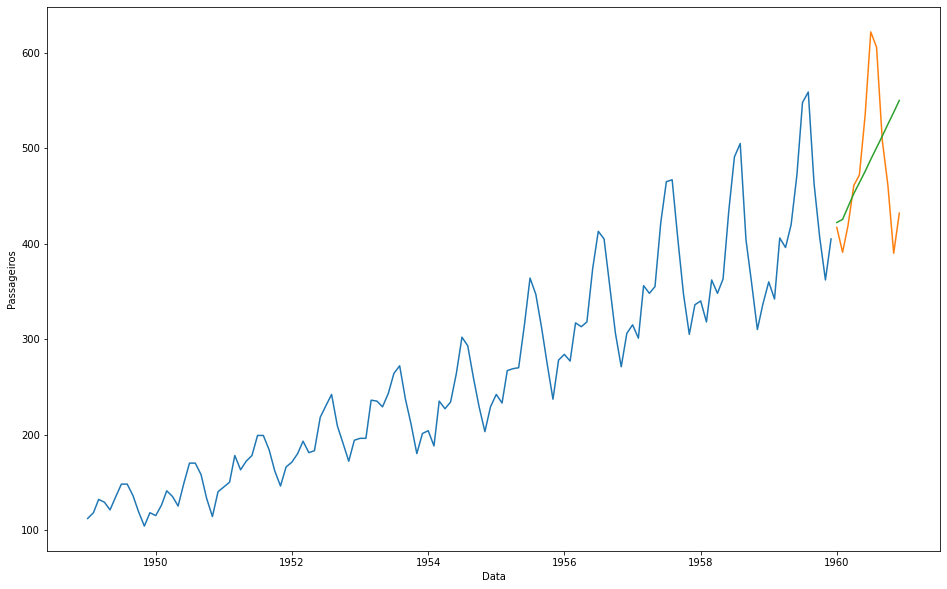

In [ ]:
dados_treino = dados_passengers.query("Ano != 1960")
dados_teste = dados_passengers.query('Ano == 1960')

modelo_arima = ARIMA(dados_treino['Passageiros'].values.astype('float32'), order=[2,2,0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

dados_teste['Previsao'] = previsao
plt.figure(figsize=(16,10))
sns.lineplot(x='Data', y='Passageiros', data= dados_treino)
sns.lineplot(x='Data', y='Passageiros', data= dados_teste)
sns.lineplot(x='Data', y='Previsao', data= dados_teste)


## Desafio 12: Visualizar as séries temporias diferenciadas (Dicas dii pandas)

## Desafio 13: Variar os parâmetros max_p(d,q)

## Desafio 14: Testar vários parâmetros para os dados de passageiros.

## Desafio 15: Plotar os valores reais e os valores previstos pelo Prophet. Fazer a mesma análise para os dados de tuberculose.